## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5 , 0.1]
redice_lr_patient = [5,10,15]


('s', 'h', '5')
('s', 'h', '10')
('s', 'h', '15')
('s', 'l', '5')
('s', 'l', '10')
('s', 'l', '15')
('a', 'h', '5')
('a', 'h', '10')
('a', 'h', '15')
('a', 'l', '5')
('a', 'l', '10')
('a', 'l', '15')
('r', 'h', '5')
('r', 'h', '10')
('r', 'h', '15')
('r', 'l', '5')
('r', 'l', '10')
('r', 'l', '15')


In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patience, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_6 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_7 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 10/25
50000/50000 [==============================] - 11s 222us/sample - loss: 1.4163 - accuracy: 0.5082 - val_loss: 1.5514 - val_accuracy: 0.4499
Epoch 11/25
50000/50000 [==============================] - 11s 230us/sample - loss: 1.3908 - accuracy: 0.5166 - val_loss: 1.5369 - val_accuracy: 0.4543
Epoch 12/25
50000/50000 [==============================] - 12s 230us/sample - loss: 1.3697 - accuracy: 0.5251 - val_loss: 1.5314 - val_accuracy: 0.4581
Epoch 13/25
50000/50000 [==============================] - 11s 225us/sample - loss: 1.3482 - accuracy: 0.5319 - val_loss: 1.5238 - val_accuracy: 0.4659
Epoch 14/25
50000/50000 [==============================] - 12s 238us/sample - loss: 1.3270 - accuracy: 0.5405 - val_loss: 1.5143 - val_accuracy: 0.4672
Epoch 15/25
50000/50000 [==============================] - 11s 229us/sample - loss: 1.3073 - accuracy: 0.5481 - val_loss: 1.5144 - val_accuracy: 0.4680
Epoch 16/25
50000/50000 [==============================] - 11s 227us/sample - loss: 1.29

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 271us/sample - loss: 2.3421 - accuracy: 0.2347 - val_loss: 2.1397 - val_accuracy: 0.2258
Epoch 2/25
50000/50000 [==============================] - 12s 231us/sample - loss: 1.8685 - accuracy: 0.3581 - val_loss: 2.0336 - val_accuracy: 0.2632
Epoch 3/25
50000/50000 [==============================] - 12s 232us/sample - loss: 1.7291 - accuracy: 0.3980 - val_loss: 1.9236 - val_accuracy: 0.3121
Epoch 4/25
50000/50000 [==============================] - 11s 225us/sample - loss: 1.6509 - accuracy: 0.4230 - val_loss: 1.8084 - val_accuracy: 0.3692
Epoch 5/25
50000/50000 [==============================] - 12s 231us/sample - loss: 1.5936 - accuracy: 0.4425 - val_loss: 1.7293 - val_accuracy: 0.3939
Epoch 6/25
50000/50000 [==============================] - 11s 228us/sample - loss: 1.5484 - accuracy: 0.4589 - val_loss: 1.6782 - val_accuracy: 0.4110
Epoch 7/25
50000/50000 [====================

50000/50000 [==============================] - 11s 229us/sample - loss: 1.2597 - accuracy: 0.5645 - val_loss: 1.5018 - val_accuracy: 0.4769
Epoch 20/25
50000/50000 [==============================] - 12s 230us/sample - loss: 1.2425 - accuracy: 0.5720 - val_loss: 1.4983 - val_accuracy: 0.4733
Epoch 21/25
50000/50000 [==============================] - 11s 224us/sample - loss: 1.2258 - accuracy: 0.5785 - val_loss: 1.4914 - val_accuracy: 0.4793
Epoch 22/25
50000/50000 [==============================] - 11s 230us/sample - loss: 1.2130 - accuracy: 0.5834 - val_loss: 1.4869 - val_accuracy: 0.4800
Epoch 23/25
50000/50000 [==============================] - 11s 223us/sample - loss: 1.1969 - accuracy: 0.5884 - val_loss: 1.4955 - val_accuracy: 0.4781
Epoch 24/25
50000/50000 [==============================] - 11s 229us/sample - loss: 1.1816 - accuracy: 0.5952 - val_loss: 1.4844 - val_accuracy: 0.4834
Epoch 25/25
50000/50000 [==============================] - 11s 223us/sample - loss: 1.1662 - accurac

Epoch 3/25
50000/50000 [==============================] - 12s 237us/sample - loss: 1.3953 - accuracy: 0.5085 - val_loss: 1.7736 - val_accuracy: 0.3655
Epoch 4/25
50000/50000 [==============================] - 12s 235us/sample - loss: 1.3200 - accuracy: 0.5338 - val_loss: 1.8096 - val_accuracy: 0.3652
Epoch 5/25
50000/50000 [==============================] - 11s 228us/sample - loss: 1.2549 - accuracy: 0.5573 - val_loss: 1.9018 - val_accuracy: 0.3367
Epoch 6/25
50000/50000 [==============================] - 12s 235us/sample - loss: 1.1979 - accuracy: 0.5759 - val_loss: 1.7748 - val_accuracy: 0.3709
Epoch 7/25
50000/50000 [==============================] - 11s 228us/sample - loss: 1.1506 - accuracy: 0.5955 - val_loss: 2.2658 - val_accuracy: 0.3064
Epoch 8/25
49152/50000 [============================>.] - ETA: 0s - loss: 1.0994 - accuracy: 0.6110
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50000/50000 [==============================] - 12s 233us/sample -

50000/50000 [==============================] - 12s 231us/sample - loss: 0.7733 - accuracy: 0.7468 - val_loss: 1.5001 - val_accuracy: 0.4987
Epoch 19/25
50000/50000 [==============================] - 11s 229us/sample - loss: 0.7444 - accuracy: 0.7580 - val_loss: 1.5204 - val_accuracy: 0.4875
Epoch 20/25
50000/50000 [==============================] - 12s 232us/sample - loss: 0.7201 - accuracy: 0.7670 - val_loss: 1.5264 - val_accuracy: 0.4904
Epoch 21/25
50000/50000 [==============================] - 11s 225us/sample - loss: 0.6948 - accuracy: 0.7757 - val_loss: 1.5404 - val_accuracy: 0.4871
Epoch 22/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.7854
Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
50000/50000 [==============================] - 11s 230us/sample - loss: 0.6694 - accuracy: 0.7859 - val_loss: 1.5556 - val_accuracy: 0.4919
Epoch 23/25
50000/50000 [==============================] - 12s 231us/sample - loss: 

Epoch 1/25
50000/50000 [==============================] - 17s 336us/sample - loss: 1.8398 - accuracy: 0.3710 - val_loss: 2.0764 - val_accuracy: 0.2611
Epoch 2/25
50000/50000 [==============================] - 13s 263us/sample - loss: 1.5301 - accuracy: 0.4669 - val_loss: 1.8209 - val_accuracy: 0.3536
Epoch 3/25
50000/50000 [==============================] - 13s 268us/sample - loss: 1.4321 - accuracy: 0.5001 - val_loss: 1.6786 - val_accuracy: 0.4151
Epoch 4/25
50000/50000 [==============================] - 13s 265us/sample - loss: 1.3634 - accuracy: 0.5254 - val_loss: 1.5946 - val_accuracy: 0.4467
Epoch 5/25
50000/50000 [==============================] - 13s 265us/sample - loss: 1.3031 - accuracy: 0.5496 - val_loss: 1.5647 - val_accuracy: 0.4473
Epoch 6/25
50000/50000 [==============================] - 13s 268us/sample - loss: 1.2579 - accuracy: 0.5654 - val_loss: 1.5106 - val_accuracy: 0.4698
Epoch 7/25
50000/50000 [==============================] - 14s 270us/sample - loss: 1.2142 - ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 20s 405us/sample - loss: 2.2741 - accuracy: 0.2570 - val_loss: 2.1521 - val_accuracy: 0.2147
Epoch 2/25
50000/50000 [==============================] - 14s 272us/sample - loss: 1.8825 - accuracy: 0.3525 - val_loss: 2.0524 - val_accuracy: 0.2595
Epoch 3/25
50000/50000 [==============================] - 13s 269us/sample - loss: 1.7712 - accuracy: 0.3831 - val_loss: 1.9326 - val_accuracy: 0.3110
Epoch 4/25
50000/50000 [==============================] - 14s 277us/sample - loss: 1.7079 - accuracy: 0.4053 - val_loss: 1.8552 - val_accuracy: 0.3424
Epoch 5/25
50000/50000 [==============================] - 14s 281us/sample - loss: 1.6623 - accuracy: 0.4205 - val_loss: 1.7768 - val_accuracy: 0.3656
Epoch 6/25
50000/50000 [==============================] - 13s 261us/sample - loss: 1.6260 - accuracy: 0.4313 - val_loss: 1.7191 - val_accuracy: 0.3914
Epoch 7/25
50000/50000 [====================

Epoch 18/25
50000/50000 [==============================] - 12s 248us/sample - loss: 0.7019 - accuracy: 0.7663 - val_loss: 1.3995 - val_accuracy: 0.5311
Epoch 19/25
50000/50000 [==============================] - 12s 245us/sample - loss: 0.6759 - accuracy: 0.7762 - val_loss: 1.4226 - val_accuracy: 0.5229
Epoch 20/25
50000/50000 [==============================] - 12s 248us/sample - loss: 0.6543 - accuracy: 0.7854 - val_loss: 1.5035 - val_accuracy: 0.5125
Epoch 21/25
50000/50000 [==============================] - 12s 241us/sample - loss: 0.6347 - accuracy: 0.7927 - val_loss: 1.4908 - val_accuracy: 0.5191
Epoch 22/25
50000/50000 [==============================] - 12s 248us/sample - loss: 0.6156 - accuracy: 0.7987 - val_loss: 1.4745 - val_accuracy: 0.5251
Epoch 23/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.8079
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
50000/50000 [==============================] - 12s 244us/sa

Epoch 1/25
50000/50000 [==============================] - 15s 298us/sample - loss: 1.9004 - accuracy: 0.3498 - val_loss: 2.1180 - val_accuracy: 0.2074
Epoch 2/25
50000/50000 [==============================] - 13s 251us/sample - loss: 1.5975 - accuracy: 0.4403 - val_loss: 1.9356 - val_accuracy: 0.2995
Epoch 3/25
50000/50000 [==============================] - 12s 243us/sample - loss: 1.4883 - accuracy: 0.4799 - val_loss: 1.7767 - val_accuracy: 0.3641
Epoch 4/25
50000/50000 [==============================] - 13s 253us/sample - loss: 1.4166 - accuracy: 0.5053 - val_loss: 1.6520 - val_accuracy: 0.4250
Epoch 5/25
50000/50000 [==============================] - 12s 249us/sample - loss: 1.3564 - accuracy: 0.5264 - val_loss: 1.6317 - val_accuracy: 0.4298
Epoch 6/25
50000/50000 [==============================] - 12s 245us/sample - loss: 1.3091 - accuracy: 0.5439 - val_loss: 1.7580 - val_accuracy: 0.3681
Epoch 7/25
50000/50000 [==============================] - 12s 247us/sample - loss: 1.2609 - ac

Epoch 19/25
50000/50000 [==============================] - 12s 246us/sample - loss: 0.8177 - accuracy: 0.7391 - val_loss: 1.3778 - val_accuracy: 0.5236
Epoch 20/25
50000/50000 [==============================] - 12s 244us/sample - loss: 0.8107 - accuracy: 0.7420 - val_loss: 1.3810 - val_accuracy: 0.5212
Epoch 21/25
50000/50000 [==============================] - 12s 244us/sample - loss: 0.8038 - accuracy: 0.7453 - val_loss: 1.3761 - val_accuracy: 0.5293
Epoch 22/25
50000/50000 [==============================] - 13s 250us/sample - loss: 0.7992 - accuracy: 0.7465 - val_loss: 1.3833 - val_accuracy: 0.5228
Epoch 23/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.7927 - accuracy: 0.7499
Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.2500000593718142e-06.
50000/50000 [==============================] - 12s 246us/sample - loss: 0.7929 - accuracy: 0.7498 - val_loss: 1.3799 - val_accuracy: 0.5236
Epoch 24/25
50000/50000 [==============================] - 12s 248us/s

Epoch 2/25
50000/50000 [==============================] - 14s 279us/sample - loss: 2.6968 - accuracy: 0.1608 - val_loss: 2.2738 - val_accuracy: 0.1573
Epoch 3/25
50000/50000 [==============================] - 14s 282us/sample - loss: 2.5879 - accuracy: 0.1825 - val_loss: 2.2418 - val_accuracy: 0.1768
Epoch 4/25
50000/50000 [==============================] - 14s 271us/sample - loss: 2.5020 - accuracy: 0.2003 - val_loss: 2.2156 - val_accuracy: 0.1954
Epoch 5/25
50000/50000 [==============================] - 13s 267us/sample - loss: 2.4324 - accuracy: 0.2163 - val_loss: 2.1987 - val_accuracy: 0.2106
Epoch 6/25
50000/50000 [==============================] - 13s 268us/sample - loss: 2.3753 - accuracy: 0.2286 - val_loss: 2.1859 - val_accuracy: 0.2299
Epoch 7/25
50000/50000 [==============================] - 13s 258us/sample - loss: 2.3269 - accuracy: 0.2410 - val_loss: 2.1746 - val_accuracy: 0.2431
Epoch 8/25
50000/50000 [==============================] - 13s 270us/sample - loss: 2.2855 - ac

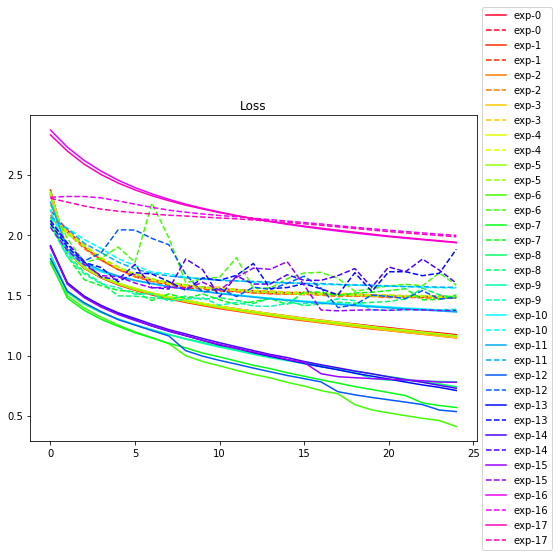

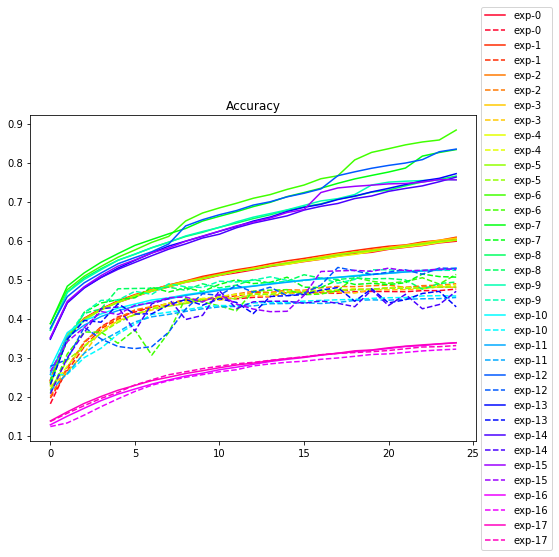

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()